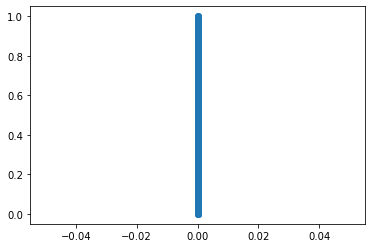

In [44]:
#!/usr/bin/env python
# coding: utf-8

# In[16]:


#!/usr/bin/env python
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lin
import quadrotor
import math


# In[25]:



robot = quadrotor.Quadrotor()

N = 1000
u_ = robot.mass*robot.g/2
z0 = np.array([1,0,0,0,0,0]).reshape([6,])
u0 = u_ * np.ones([2,1])
o = 2*math.pi/10
r = 1
T = 10
x_desired = [r*math.cos(o*(T/N)*i) for i in range(0,N+1)]
y_desired = [r*math.sin(o*(T/N)*i) for i in range(0,N+1)]
vx_desired = [-r*o*math.sin(o*(T/N)*i) for i in range(0,N+1)]
vy_desired = [ r*o*math.cos(o*(T/N)*i) for i in range(0,N+1)]
theta_desried = [0 for i in range(0,N+1)]
omega_desried = [0 for i in range(0,N+1)]

v = 1/10
v= v
x_desired = [0 for i in range(0,N+1)]
y_desired = [v*i*T/(N) for i in range(0,N+1)]
vx_desired = [0 for i in range(0,N+1)]
vy_desired = [v for i in range(0,N+1)]
theta_desried = [0 for i in range(0,N+1)]
omega_desried = [0 for i in range(0,N+1)]
state_desired = np.array([x_desired,vx_desired,y_desired,vy_desired,theta_desried,omega_desried])
horizon_length = 1000
z0 = state_desired[:,0]


# In[17]:


plt.figure()
plt.scatter(x_desired,y_desired)

plt.show()


In [45]:
state_desired/2

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.0005, 0.001 , ..., 0.499 , 0.4995, 0.5   ],
       [0.05  , 0.05  , 0.05  , ..., 0.05  , 0.05  , 0.05  ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]])

In [54]:
%%time
def tracking_desired_LQR_controller(state,i):
    N = 1000
    state = state.reshape(6, 1)
    assert state.shape == (6, 1)
    assert state_desired.shape ==(6,N+1)
    Q = 50 * np.diag([1,0,1,0,0,0])
    R = 0.001*np.identity(2)
    
    u_star = robot.mass * robot.g / 2
    
    x_star = state_desired[:,i].reshape([-1,1])
    x_bar = state - x_star
    u_star = u_star * np.ones([2, 1])
    u = u_star
    
    A, B = robot.get_linearization(state.reshape([6, 1]), u.reshape([2, 1]))

    def solve_LQR_trajectory(A, B, Q, R, x_bar, N):
        '''
        '''
        K_gains = []
        k_feedforward = []
        PN = Q
        qn = -np.dot(Q, x_bar/2)
        pn = qn[:, N]
        for i in range(N):
            bpb = np.dot(np.dot(np.transpose(B), PN), B)
            bpbr = -np.linalg.inv(bpb + R)
            K = np.dot(np.dot(np.dot(bpbr, np.transpose(B)), PN), A)
            P = Q + np.dot(np.dot(np.transpose(A), PN), A) + np.dot(np.dot(np.dot(np.transpose(A), PN), B), K)
            k = np.dot(np.dot(bpbr, np.transpose(B)), pn)
            pn = qn[:, N - 1 - i] + np.dot(np.transpose(A), pn) + np.dot(np.dot(np.dot(np.transpose(A), PN), B), k)
            K_gains.append(K)
            k_feedforward.append(k)
            PN = P
        K_gains.reverse()
        k_feedforward.reverse()
        return K_gains, k_feedforward
    
    K_gains, k_feedforward = solve_LQR_trajectory(A,B,Q,R,state_desired[:,i:],N-i)
    K=K_gains[0]
    k = k_feedforward[0].reshape([-1,1])
    ut = K.dot(x_bar) + k + u
    return ut.reshape(-1)

t, state, u = robot.simulate(z0,tracking_desired_LQR_controller, horizon_length, disturbance = False)


# In[19]:




Wall time: 30.2 s


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAALIJtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA23ZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0agX3rQrxAFVDm
jgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzzgStuUpMltOrgd3xiXeRy
NijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6aV0xf5e1Y3eMSRhlnOEg
5t6laqwn4ehgEZ2RN/0//u4oRdcLYjvj7rDRnH5cb7OVcVeDDGblDP4oiq80WQOVQ/kvRcX6GntS
Tyf2SkA1tyCNIyktbublNs2xhPCwz3kf2rP4S8jvTxqEdS7q8r7UnnwkyNZtsidmfggEoAALuDpT
UqgO2Nyc/nyo2P8mgMLl9W2v4DablAAh40KXLQOiQA0eTXhSNU48dP9tF0wwuFwd4UGlWZaNRk+c
PEQ/GeZ0B3tBqqih8K40vtZGgyZSX/Cllsgqdg87QMUDgaJ7ASAyDb/CkU0nALDfO+cnRvfZl6Sl
9fLa1LK9B3Q1wTbHr5w1s3/m8ux2rJaVHDZCUV/y38xSEO80k+48n4ueT6r6VDh4ujgolzbZLj9d
/49jd6q5J0Apc+ZRvsR0TaOEO5b8o0ujSeIOIgkhOahi4LpV4bVwK7he/ZWo2EuAlsgT8wA30ZbL
wxWrckoxjTmGltHrkOT94ux0DHMECvahXEYWRP8+EZ9m2FtbGM87U5PlU64eUabBTV3Wnsn0B/2R
juUaQEeRisjjK6w9xhThdeSIEFeZ92nFAAADALUJmMzIrlzbZgF1CUqCXUqRwKxHFQu+PTuUm9oT
/Vy3SzoQFPDMT5Ra6nIZNf287fjlo2z/A1D/hXVu69U4jR1B5LgHGGFfma/S8zYm00FY9HJpLUQI
o8vr8x2jOojPA/pyd34cdKKxgRl4bSAipTKY9OevUjE/+kGCaCbwEVK1ZNMeMszFDrRxiXUrh7Wb
eELWicEcHDHF9aCFrlQXQgwzuRotpH7hqg8AMClCEjNHTuf1cVlp78zbFX18BWbBnDYyKYYb6z4D
I7n28etNoeKwPu74SQDdSX/pUDTBJBfj2EmBdn9b2VbHKwoW3v1fsf/IB9Mj+RHjncVs2n/es6YD
kK+IQctQMRQc9m5ocwLXIsZgAV1RoIQF3gKqDiTN3p1fAulfVDnOoYe99FI8wy3H1I88izbQwXdj
hPhVsLGNsUMccTvJ+PzC3tkpA4Blg7GHkaaqf/9ytGvingMUZv651DuVYaNuCUj/s/yzN7wauY4i
s3aK8rQO99LUKM65u29XoUbHCMaEtDSsIZh5TZYucUFnX6iElA3QUWO0bTcQjtnX/z5A32oReNpW
IzxJovjBPaz8Nlkcnr06H6R82KmIPX1Tt3sRr4GHNcU1+paVGtEGQQFNJIg6nRGhtDegpbQNWY5r
LXSy+NICpPKMIOT9m/ey62SSqXrN+y7TbM7Ovo34eA9P+6b8rs6bqYtfdI1MtysWH9dk/pqayyjx
7jMQWT+1q49AUkAAAAMAAD/Tdj5oPHD+CBsKBNvZ77YMn5YJ0r7SZzbFnDSG22yVVTQPxzAzdI/+
/5fg4PzBiHo6Tc6J2Dt+h3KhPXrLLSP1dxKx5IyRqY+ktqxAaJ2/C37i4PV9JMv1GLvM1uCpF4/q
XCVeZ7jYT2ZH0FOmlVhZ/niAo1QNDJetnulI1PH3ShMjA+MQkulqbjtbdcAi+Ywi+eNjT5SyIyps
lDQeAyte7bhHaEbPIFTD53lYZUDfuCNi5Mz9IJTpNFNxEoqMLsHIdvQVmBAhFlxGfshsX0unU8st
Ti1XK+2FdHRmUY0RF0lWCrlkqyWq4OAIuZ8xw+xrMeh0Rq68CB/bkNLFp5wv21tXiY7WSlK/oJf4
xyzhm3t83dy9VOjOm6lzKOaO3g1dCNi2mysuQ6Fdqut5r8aQKMJ6C6UqhTurOXi5JM+r5dF6Uqzc
ubo3cElFjC3Vc/+PAVinONfOgeCJIHa/QkM5HRPJelXjH9xPjIWz1iRcaElOhVLFo0Va4wuF4Bvm
cJrv9vz9+C6FiiPPh+un2gQCMPSEbpF5/Ks2PlYlHVsSY7/TyXiYRKLse5ylEMglldS780H3/1+W
WZNavzdnVcQT/cFqGolLn5KqqwxqRFc/fAABhe8+KgAAOUa9WstI1WsmhnXoJXIF8ygnCNf9OIb2
QosABH8yQ5nLM5qnFcOGHxHlckpPZNSTJtrDF1vNg689tPPPql4s4NdO78F10+OPBcWcRXw6ThhM
QFjdLtmUq0eIhsmaK9VyL+O5wlkdWHv5/wtM89fjfsVVJIxTd1TrWxwDF3lZ4fhjWdORDGlSvD59
HK8ZLgLmV/XC1QRVf1yyaVXzBIH5V6NBTd8Xm5nmeImk0yuF72wsh1GkkYrly73hY8jtIlPCMhKo
en7w3ndmj8bTFo+9ldWtn005E0ouRUxqyDMDqh52Ih3nDdJCPdEMFUj2W6qNXexHbCY4ZteuPfVl
IQ+enCGqvqifXuopkIraxsz7h+VAAAADAAADAyZuDxNvc28czGHcRQRMtpCq1cP/hEgyTiZapy0G
RyuHgXYKLCEx5hm3gLPf/FOdNQNon37ZpysUM20mA4VVQrYa78n7tfDOOUvM0Bl9hBXAeYG5dFei
Krmzahwg6FeltUDPD9ToALsm2OOxSl0Dt8SlvcOiveNSZatnpkv0E5Li/NjMucnnf30+xoh7cgg0
2PTATFWc5y8w9MbH+Gzz38L9IvK7sL0QxNHy+VBD1T+b49Sdi/r0k11Xwn4T8PcCfBZCSOm2fzQp
z/hecC3BKWazpP7Cp2G2t3FOalI52dkJWG6IHYOoV0QEBwgI2TdAAAAM4BhRMEShoxu9ACuwNwBm
pwuEKHN/3VX3vzButNYBx

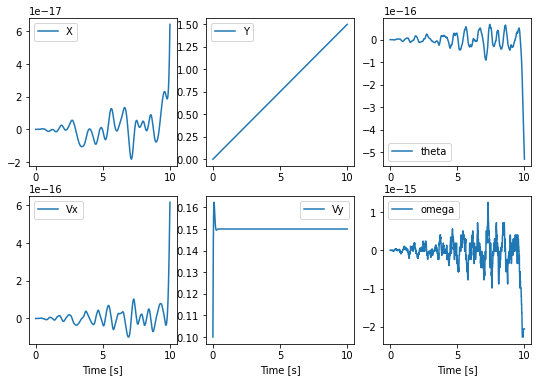

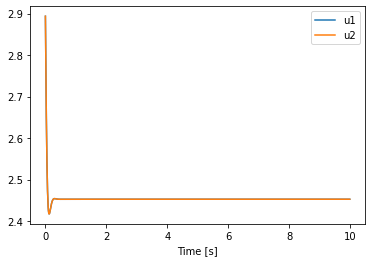

In [55]:
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')
robot.animate_robot(state,u)

